### Project Libraries


In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import networkx as nx
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from scipy.stats import gaussian_kde
from IPython.display import display, clear_output
from scipy import stats
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from sklearn.exceptions import UndefinedMetricWarning
simplefilter("ignore", category=UndefinedMetricWarning)
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from scipy.optimize import minimize
from scipy.optimize import Bounds


%matplotlib inline

### Initial data reading
#### Read in sales data and Display First 5 Rows

In [4]:
data_2021 = pd.read_csv('2021_focus.csv')
data_2022 = pd.read_csv('2022_focus.csv')
purchasing = pd.read_csv('Orders.csv')
data_2021=data_2021.dropna(how='all')
data_2022=data_2022.dropna(how='all')
all_sales = pd.read_csv('All_Sales.csv')

print(data_2021.head())
print(data_2022.head())
print(purchasing.head())



                      Name  Price  Units   Sales Category
0                      666   5.89     14   82.46       LV
1  $5 Old Fasioned Mondays   5.00     49  245.00       LV
2          10.30 drag shot   4.00     14   56.00       LV
3         Six & Twenty Rum   9.00     13  117.00       LS
4               6&20 Vodka   9.00      5   45.00       LS
                             Prod  Price  Week 3/7/2022 - 3/9/2022 Net Units  \
0                             666   5.89                                   0   
1                      6&20 Vodka   9.00                                   0   
2  Six & Twenty Old Money Whiskey   9.00                                   0   
3                     6-pack TOGO  20.00                                   0   
4                   Aberlour 12yr   9.50                                   0   

   Week 3/7/2022 - 3/9/2022 Net Sales  Month 3/1/2022 - 3/9/2022 Net Units  \
0                                 0.0                                    0   
1              

#### Check for nulls

In [5]:
# BC
# check the dataframe for null values
print(data_2021.isnull().values.any())
print(data_2022.isnull().values.any())
print(purchasing.isnull().values.any())

False
False
True


#### Check data types

In [6]:
# BC
# checking datatypes in the dataframes
print(data_2022["Price"][0])
print(type(data_2022["Price"][0]))
print(data_2022["Category"][0])
print(type(data_2022["Category"][0]))
print(purchasing["ORDER UNIT"][0])
print(type(purchasing["ORDER UNIT"][0]))
print(purchasing["ORDER UNIT"][399])
print(type(purchasing["ORDER UNIT"][399]))
# 1 is being interpreted as a string in purchasing

5.89
<class 'numpy.float64'>
LV
<class 'str'>
1
<class 'str'>
1/6 Barrel
<class 'str'>


In [7]:
# BC
# identify where there are null values in purchasing
nan_indices = np.where(purchasing.isnull())
nan_columns = np.unique(nan_indices[1])
nan_rows = np.unique(nan_indices[0])

print('Rows with missing values are:')
purchasing.iloc[nan_rows, nan_columns]

Rows with missing values are:


,ORDER DATE,DISTRIBUTOR
910,NaN,Tony's
1172,3/29/2021,NaN
1173,3/29/2021,NaN


#### Cut Down 2022 so it matches 2021 Format <br> Combine 2021 and 2022 into superset with additional year column.

In [8]:
narrow_2022 = data_2022.drop(data_2022.columns[[2,3,4,5]],axis=1)

narrow_2022.columns=data_2021.columns
data_2021['year']=2021
narrow_2022['year']=2022
all_sale=data_2021.append(narrow_2022)
print(narrow_2022)


                                 Name  Price  Units   Sales Category  year
0                                 666   5.89      2   11.78       LV  2022
1                          6&20 Vodka   9.00      2   18.00       LS  2022
2      Six & Twenty Old Money Whiskey   9.00      7   63.00       LS  2022
3                         6-pack TOGO  20.00      1   20.00       BI  2022
4                       Aberlour 12yr   9.50      3   28.50       LV  2022
..                                ...    ...    ...     ...      ...   ...
320                     White Russian   3.00     35  105.00       LD  2022
321  Wicked Weed Freak of Nature DIPA   5.75     61  345.00       SI  2022
322                  Woffler Dry Rose   9.00     21  189.00       BI  2022
323                  Woodford Reserve   7.50     45  300.00       LB  2022
324       Young's Dbl Chocolate Stout   8.00     12   96.00       BI  2022

[325 rows x 6 columns]


C:\Users\joepa\AppData\Local\Temp\ipykernel_24264\679841570.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sale=data_2021.append(narrow_2022)


#### Aggregate the purchasing data. Aggregate the sales data. Note, no buying data for 2022 so just use 2021.

In [9]:
purchasing_aggregate=purchasing.groupby('ITEM',as_index=False).agg({'ORDER DATE':'last','Type':'first','DISTRIBUTOR':'first','UNIT COST':'max','ORDER UNIT':'first','TOTAL COST':'sum'})
print(purchasing_aggregate.head())

sales_aggregate=all_sales.groupby(['Name'],as_index=False).agg({'Year':'first','Price':'mean','Units':'sum','Sales':'sum','Category':'first','Category_2':'first'})
print(sales_aggregate.head())

                  ITEM  ORDER DATE        Type DISTRIBUTOR  UNIT COST  \
0         A&W Rootbeer   6/22/2021       Mixer     Greenco      21.50   
1        Aberlour 12yr    2/1/2021      Liquor      Tony's      45.99   
2         Absolut Pear    3/6/2021      Liquor      Tony's      22.70   
3  Ace Cider Perry Can  10/14/2021  Can/Bottle    Southern      35.16   
4     Allagash Curieux  11/30/2021  Can/Bottle          KW      79.00   

  ORDER UNIT  TOTAL COST  
0          1      106.50  
1          1       45.99  
2          1       22.70  
3          1       70.32  
4          1      158.00  
                      Name  Year  Price  Units   Sales Category Category_2
0  $5 Old Fasioned Mondays  2021   5.00     49  245.00       LV    Spirits
1         $5 vELO carbombs  2022   4.43     69  305.67       LV    Spirits
2        $7 Irish  Goodbye  2022   7.00      6   42.00       LV    Spirits
3          10.30 drag shot  2021   4.00     14   56.00       LV    Spirits
4            11.4 Cockta

#### Left join on all purchasing to include cost. <br> Lets also remove any items that were sold that don't have directly corresponding orders so we can perform more in depth analysis.

In [10]:
combined_purchase_sales=sales_aggregate.set_index('Name').join(purchasing_aggregate.set_index('ITEM'),how='left')
purchase_sales_joint=combined_purchase_sales[combined_purchase_sales['TOTAL COST'].notna()]

#### Lets calculate a couple columns to find out some more information related to profitability, and also aggregate items that have sold at different prices.


In [11]:
pd.options.mode.chained_assignment = None #this warning has been researched and is a false positive in this context
purchase_sales_joint['Quantity']=purchase_sales_joint['TOTAL COST']/purchase_sales_joint['UNIT COST']
purchase_sales_joint['Profit per unit']=(purchase_sales_joint['Sales']-purchase_sales_joint['TOTAL COST'])/purchase_sales_joint['Units']
purchase_sales_joint['Profit']=purchase_sales_joint['Sales']-purchase_sales_joint['TOTAL COST']
purchase_sales_joint['Cost Percentage']=(purchase_sales_joint['TOTAL COST']/purchase_sales_joint['Units'])/(purchase_sales_joint['Sales']/purchase_sales_joint['Units'])
purchase_sales_joint['Sale Unit Cost']=purchase_sales_joint['TOTAL COST']/purchase_sales_joint['Units']
print(purchase_sales_joint.sort_values('Profit',ascending=False).head(5))
print(purchase_sales_joint.sort_values('Profit').head(5))

                     Year     Price  Units     Sales Category Category_2  \
Name                                                                       
Coors Banquet 18pk   2022  4.964444  28025  76517.90       BI       Beer   
George Dickel        2021  3.571429  17562  64517.65       LV    Spirits   
Deep Eddy Vodka      2021  3.851667  12545  44665.91       LD    Spirits   
Draft Trifecta IPA   2021  6.500000   6428  43219.00       BI       Beer   
El Jimador Reposado  2020  3.750000   8200  31616.00       BI       Beer   

                     ORDER DATE        Type DISTRIBUTOR  UNIT COST  \
Name                                                                 
Coors Banquet 18pk   10/12/2021  Can/Bottle     Greenco      20.06   
George Dickel          2/1/2021      Liquor      Tony's      20.99   
Deep Eddy Vodka       3/29/2021      Liquor      Tony's      12.80   
Draft Trifecta IPA     2/9/2021         Keg     Greenco     185.00   
El Jimador Reposado    3/3/2021      Liquor    

### Classifier


#### Scaling to prep for classifier build. Seek to identify if the type of product can be predicted based on the units sold, the cost percentage, and the profit generated.<br>Also see if the product can be predicted based on the profit per unit, cost percentage, and units sold.

In [12]:
pred_set_1=purchase_sales_joint[['Units','Type','Cost Percentage','Profit']]
pred_set_2=purchase_sales_joint[['Units','Type','Cost Percentage','Profit per unit']]
x_1=pred_set_1[['Cost Percentage','Profit','Units']]
scaler_1=preprocessing.StandardScaler()
scaler_1.fit(x_1)
x_1=scaler_1.transform(x_1)
x_2=pred_set_2[['Cost Percentage','Profit per unit','Units']]
scaler_2=preprocessing.StandardScaler()
scaler_2.fit(x_2)
x_2=scaler_2.transform(x_2)

y_1=pred_set_1['Type']
y_2=pred_set_2['Type']

#### Build Classifier

In [13]:
from sklearn.model_selection import train_test_split
x_1_train, x_1_test, y_1_train, y_1_test= train_test_split(x_1,y_1,test_size=.66,random_state=0)

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np

range_k = range(1,50)
scores={}
scores_list=[]

for k in range_k:
    classifier = KNeighborsClassifier(n_neighbors=k,metric='minkowski')
    classifier.fit(x_1_train,y_1_train)
    y_pred=classifier.predict(x_1_test)
    scores[k]=metrics.accuracy_score(y_1_test,y_pred)
    scores_list.append(metrics.accuracy_score(y_1_test,y_pred))
result=metrics.confusion_matrix(y_1_test,y_pred)

k_opt=np.argmax(scores_list)
score=max(scores_list)
print(f'Optimal K value for the profit classification is {k_opt} and maximum score is {score}')

x_2_train, x_2_test, y_2_train, y_2_test= train_test_split(x_2,y_2,test_size=.66,random_state=0)

scores={}
scores_list=[]

for k in range_k:
    classifier = KNeighborsClassifier(n_neighbors=k,metric='minkowski')
    classifier.fit(x_2_train,y_2_train)
    y_pred=classifier.predict(x_2_test)
    scores[k]=metrics.accuracy_score(y_2_test,y_pred)
    scores_list.append(metrics.accuracy_score(y_2_test,y_pred))
print(metrics.confusion_matrix(y_2_test,y_pred))
k_opt=np.argmax(scores_list)
score=max(scores_list)
print(f'Optimal K value for the profit per unit classification is {k_opt} and maximum score is {score}')


Optimal K value for the profit classification is 9 and maximum score is 0.6243654822335025
[[  0  36   0   0]
 [  0 106   0   0]
 [  0  48   0   0]
 [  0   7   0   0]]
Optimal K value for the profit per unit classification is 6 and maximum score is 0.6548223350253807


Outline:
Numeric EDA of Sales/Order Combined Set + Combined Sales + Orders BC
    Single Variable
        Metrics done
        Boxplot done
            Numeric
        Histogram done
            Categorical
    Multivariate
        Heatmap
        Seaborn pairplots
Regression BC
    Multivariate on Combined dataset with y as sa profit and x as remaining variables
        Remove variables that are not a good predictor of profit
        Add 3d scatter
Compare sales in q1 2017 q1 2018 q1 2019 q1 2021 to q1 2022
    I need to pull this data

Product ordering JP
    Pricing vs sales
Utilization of pricing model paper model JP
    Use per unit cost to clasify products within each Type as high, medium, or low quality category
        Either use price cutoffs (hard)
    Use estimated sales change percentages from paper table 5
    Loop through the price change for percent increases in each product on individual product basis.
    Generate optimal price for each one.
    
    


### Exploratory Data Analysis


#### all_sales

In [14]:
# check the dataframe for null values
print(all_sales.isnull().values.any())
print(all_sales.head())
print(type(all_sales["Price"][0]))
print(type(all_sales["Units"][0]))
print(type(all_sales["Sales"][0]))
print(type(all_sales["Year"][0]))
print(type(all_sales["Category"][0]))
print(type(all_sales["Category_2"][0]))

False
                      Name  Price  Units   Sales  Year Category Category_2
0                      666   5.89     14   82.46  2021       LV    Spirits
1                      666   5.89      2   11.78  2022       LV    Spirits
2                      666   5.89    126  724.47  2019       LV    Spirits
3                      666   5.89     16   94.24  2020       LV    Spirits
4  $5 Old Fasioned Mondays   5.00     49  245.00  2021       LV    Spirits
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'str'>
<class 'str'>


In [15]:
# convert columns data format to float/int
# all_sales["Sales"] = pd.to_numeric(all_sales["Sales"], downcast="integer")
# corrected in the excel CSV file

# identify where there are null values in all_sales
nan_indices = np.where(all_sales.isnull())
nan_columns = np.unique(nan_indices[1])
nan_rows = np.unique(nan_indices[0])

print('Rows with missing values are:')
all_sales.iloc[nan_rows, nan_columns]

Rows with missing values are:


""


                Metrics      Price          Units         Sales
0               Maximum  40.000000   12964.000000  3.498661e+04
1               Minimum   1.000000       1.000000  0.000000e+00
2                  Mean   6.778170     141.167668  7.062039e+02
3                Median   6.000000      31.000000  1.957500e+02
4    Standard Deviation   4.323116     528.428675  1.915488e+03
5              Variance  18.689328  279236.864222  3.669094e+06
6  Inter-quartile Range   2.000000      84.000000  4.942500e+02
7              Skewness   4.269478      13.122711  8.303601e+00
8              Kurtosis  22.032232     243.611784  1.002976e+02


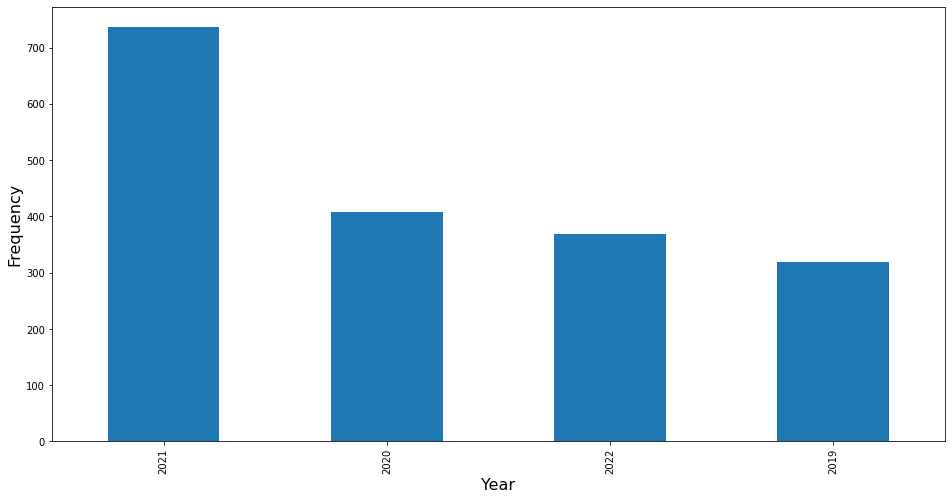

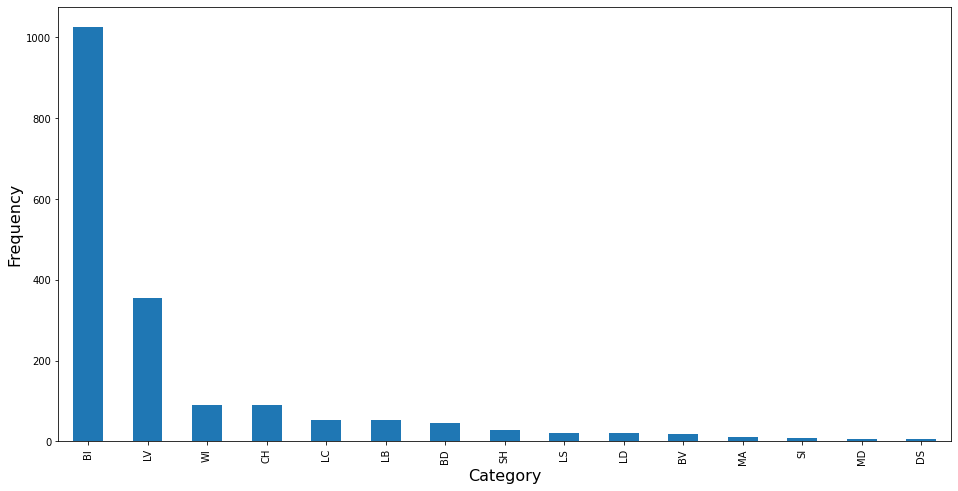

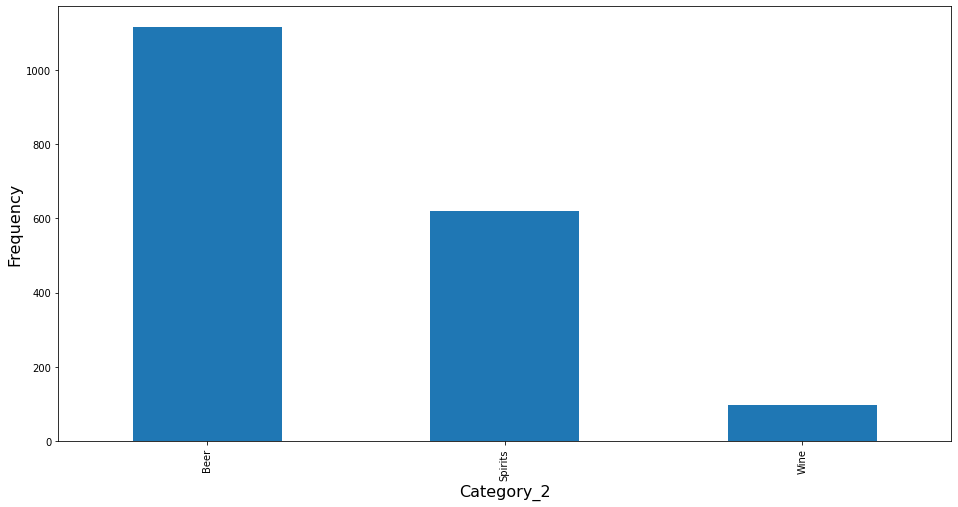

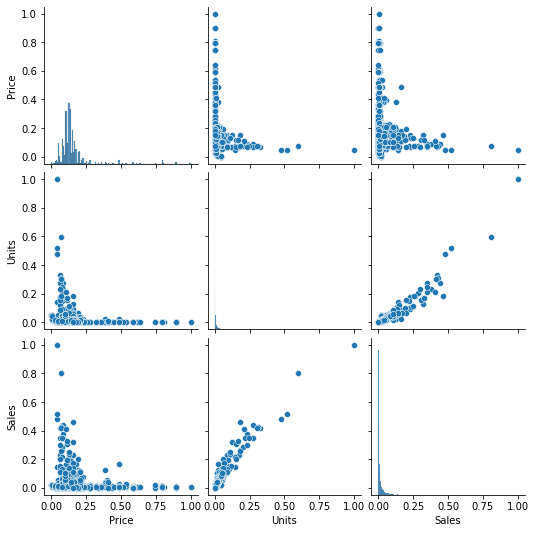

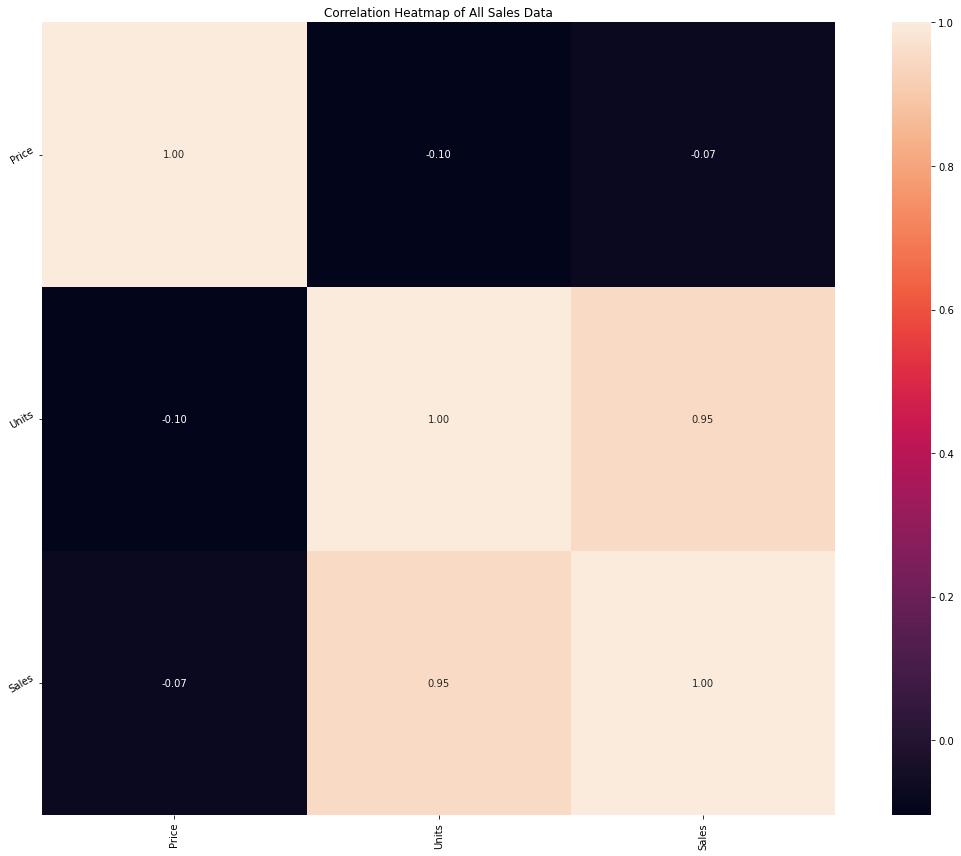

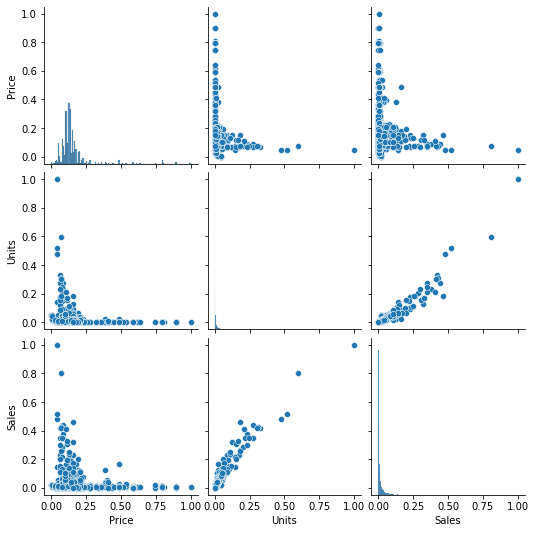

In [16]:
# Single Variable EDA
# Create metrics dataframe
eda_rows = ['Maximum','Minimum','Mean','Median','Standard Deviation','Variance','Inter-quartile Range','Skewness','Kurtosis']
# create empty lists to store values
maximum=[]
minimum=[]
mean=[]
median=[]
standard_deviation=[]
variance = []
IQR=[]
skew=[]
kurt=[]

all_sales_numeric = all_sales.copy()
all_sales_numeric = all_sales_numeric.drop(["Name","Year","Category","Category_2"], axis=1)
all_sales_numeric_columns = all_sales_numeric.columns.tolist()

for i in all_sales_numeric_columns:
    maximum.append(all_sales_numeric[i].max())
    minimum.append(all_sales_numeric[i].min())
    mean.append(all_sales_numeric[i].mean())
    median.append(all_sales_numeric[i].median())
    standard_deviation.append(all_sales_numeric[i].std())
    variance.append(all_sales_numeric[i].var())
    Q1 = all_sales_numeric[i].quantile(0.25)
    Q3 = all_sales_numeric[i].quantile(0.75)
    IQR.append(Q3-Q1)
    skew.append(all_sales_numeric[i].skew())
    kurt.append(all_sales_numeric[i].kurtosis())

all_sales_metrics = pd.DataFrame([maximum, minimum, mean, median, standard_deviation, variance, IQR, skew, kurt])
all_sales_metrics.columns = all_sales_numeric_columns
all_sales_metrics.insert(0, 'Metrics', eda_rows)
print(all_sales_metrics)


# Interactive Boxplots
fig = make_subplots(rows=1, cols=3)
for count, variable in enumerate(all_sales_numeric_columns):
    fig.add_trace(go.Box(y=all_sales[variable], name=variable, marker_color='#3D9970', boxmean=True, 
                       boxpoints='outliers',fillcolor='#2bc531',
                       quartilemethod="linear", showlegend=False),row=1,col=count+1)
fig.update_layout(height=750, width=750, title_text="Boxplots of All Sales Data")    
fig.show()

# Histogram
all_sales_categorical = all_sales.copy()
all_sales_categorical = all_sales_categorical.drop(["Name","Price","Units","Sales"], axis=1)

for category in all_sales_categorical.columns.tolist():
    plt.figure(figsize=(16,8))
    all_sales[category].value_counts().plot.bar()
    plt.xticks(rotation=90)
    plt.xlabel(category, fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.show()

# Normalization
# setting scaler option to 0,1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(all_sales_numeric)

# normalize all sales
norm_all_sales = scaler.transform(all_sales_numeric).T
# create empty dataframe and append column values with column name by iteration
norm_all_sales_df = pd.DataFrame()
for count, variable in enumerate(all_sales_numeric_columns):
    norm_all_sales_df[variable]=norm_all_sales[count]
# show normalized cancer dataframe
norm_all_sales_df

# Pair Plots
response_factors = all_sales_numeric_columns
# plot pairplot using seaborn
sns.pairplot(norm_all_sales_df[response_factors], kind='scatter', diag_kind='hist')
plt.show()

# Box Plots of Normalized Data 
fig = make_subplots(rows=1, cols=3)
for count, variable in enumerate(all_sales_numeric_columns):
    fig.add_trace(go.Box(y=norm_all_sales_df[variable], name=variable, marker_color='#3D9970', boxmean=True, 
                       boxpoints='outliers',fillcolor='#2bc531',
                       quartilemethod="linear", showlegend=False),row=1,col=count+1)

fig.update_layout(height=750, width=750, title_text="Boxplots of Normalized All Sales")

fig.show()

# Multivariable EDA
# Heatmap using normalized data
# compute pairwise pearson correlation of columns, excluding null values
correlation = norm_all_sales_df.corr(method='pearson')
# plotting the heatmap
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of All Sales Data')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)   
plt.tight_layout()        
plt.show()

# Pair Plots
response_factors = all_sales_numeric_columns
# plot pairplot using seaborn
sns.pairplot(norm_all_sales_df[response_factors], kind='scatter', diag_kind='hist')
plt.show()

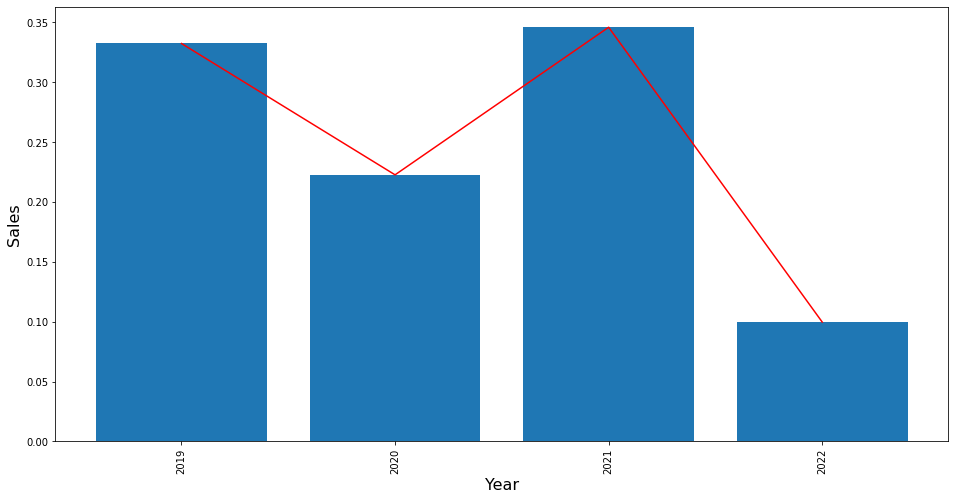

0.3321468989143383 0.22253328298761255 0.34570537274297375 0.09961444535507558


In [17]:
# year to year sales
sales_list = list(all_sales.groupby('Year')['Sales'].apply(list).values)
sales_2019=sum(sales_list[0])
sales_2020=sum(sales_list[1])
sales_2021=sum(sales_list[2])
sales_2022=sum(sales_list[3])
sum_sales=sum([sales_2019,sales_2020,sales_2021,sales_2022])
sales_2019=sales_2019/sum_sales
sales_2020=sales_2020/sum_sales
sales_2021=sales_2021/sum_sales
sales_2022=sales_2022/sum_sales
plt.figure(figsize=(16,8))
plt.bar([2019,2020,2021,2022],[sales_2019,sales_2020,sales_2021,sales_2022])
plt.plot([2019,2020,2021,2022],[sales_2019,sales_2020,sales_2021,sales_2022],color='red')
plt.xticks(range(2019,2023),rotation=90)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Sales", fontsize=16)
plt.show()
print(sales_2019,sales_2020,sales_2021,sales_2022)

### Exploratory Data Analysis
#### purchase_sales_joint

                Metrics      Price         Units         Sales    UNIT COST  \
0               Maximum  22.363636  2.802500e+04  7.651790e+04   190.000000   
1               Minimum   3.333333  2.000000e+00  1.500000e+01     5.990000   
2                  Mean   6.562095  5.566409e+02  2.671528e+03    66.031644   
3                Median   6.000000  7.500000e+01  4.850000e+02    72.000000   
4    Standard Deviation   2.689102  2.206641e+03  7.710850e+03    34.080398   
5              Variance   7.231270  4.869266e+06  5.945721e+07  1161.473539   
6  Inter-quartile Range   1.491071  1.922500e+02  1.227140e+03    49.840000   
7              Skewness   3.389567  8.975114e+00  6.322680e+00     0.955329   
8              Kurtosis  14.034806  9.557544e+01  4.760075e+01     2.144603   

      TOTAL COST    Quantity  Profit per unit        Profit  Cost Percentage  \
0    9139.740000  455.620140        13.945640  6.737816e+04         4.061538   
1      16.800000    1.000000       -19.900000 -4.

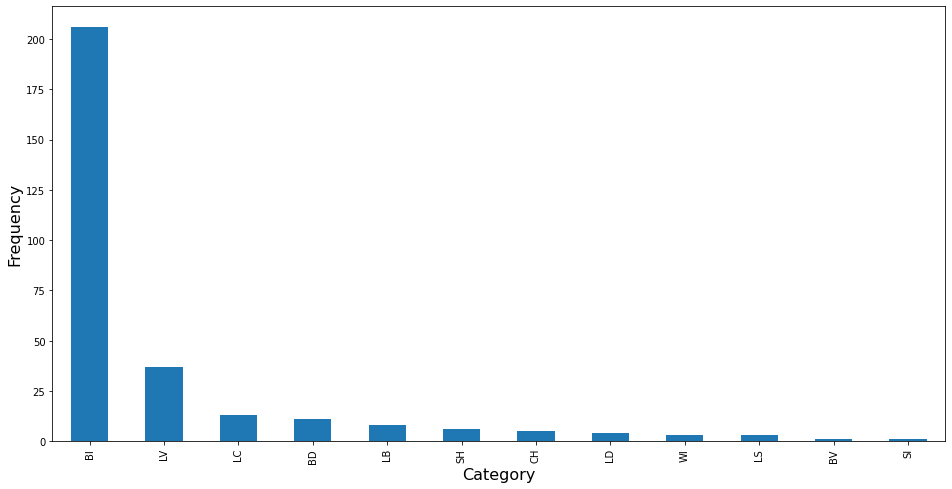

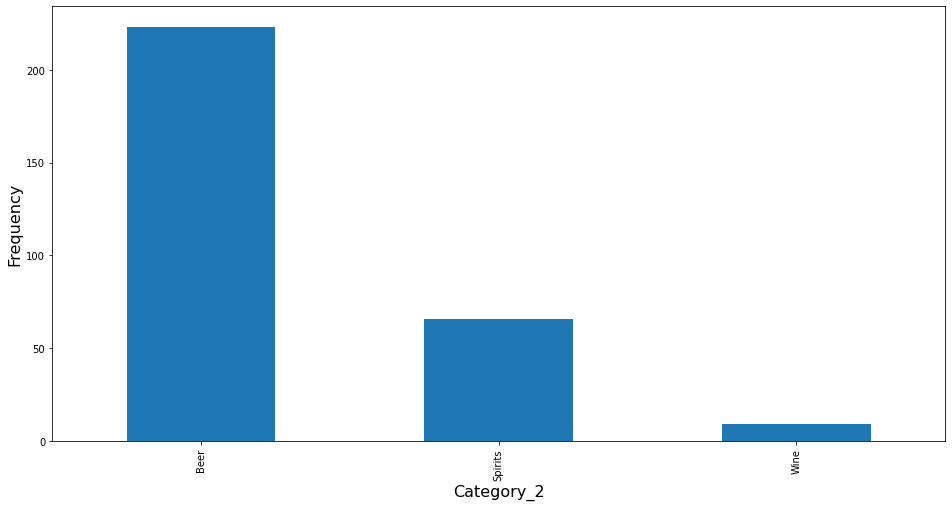

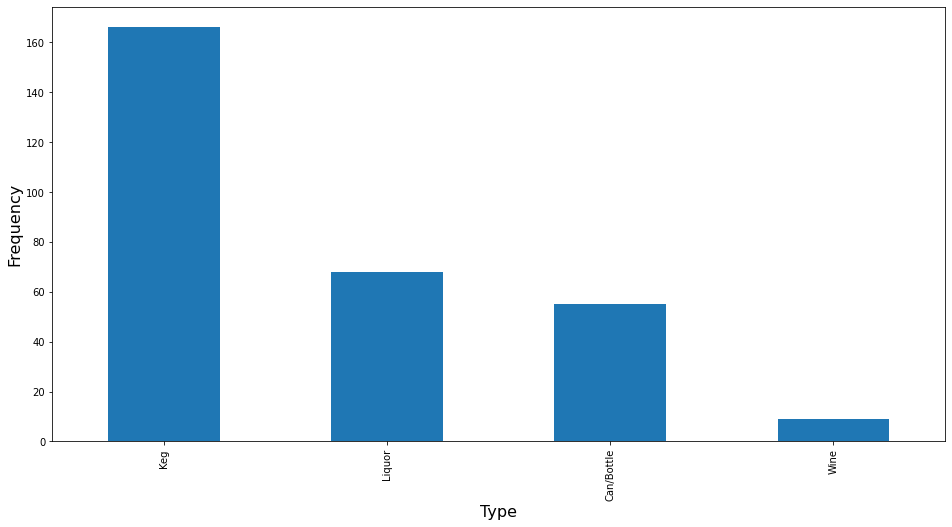

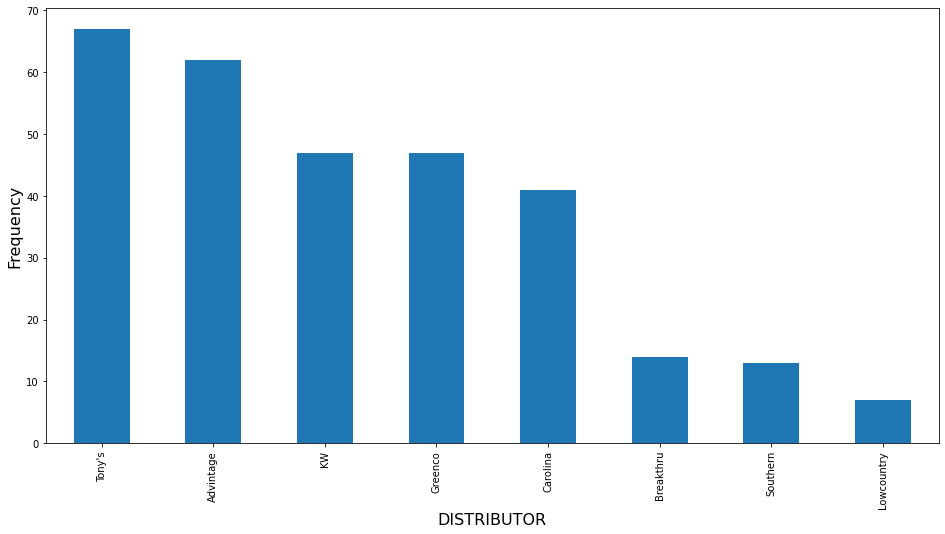

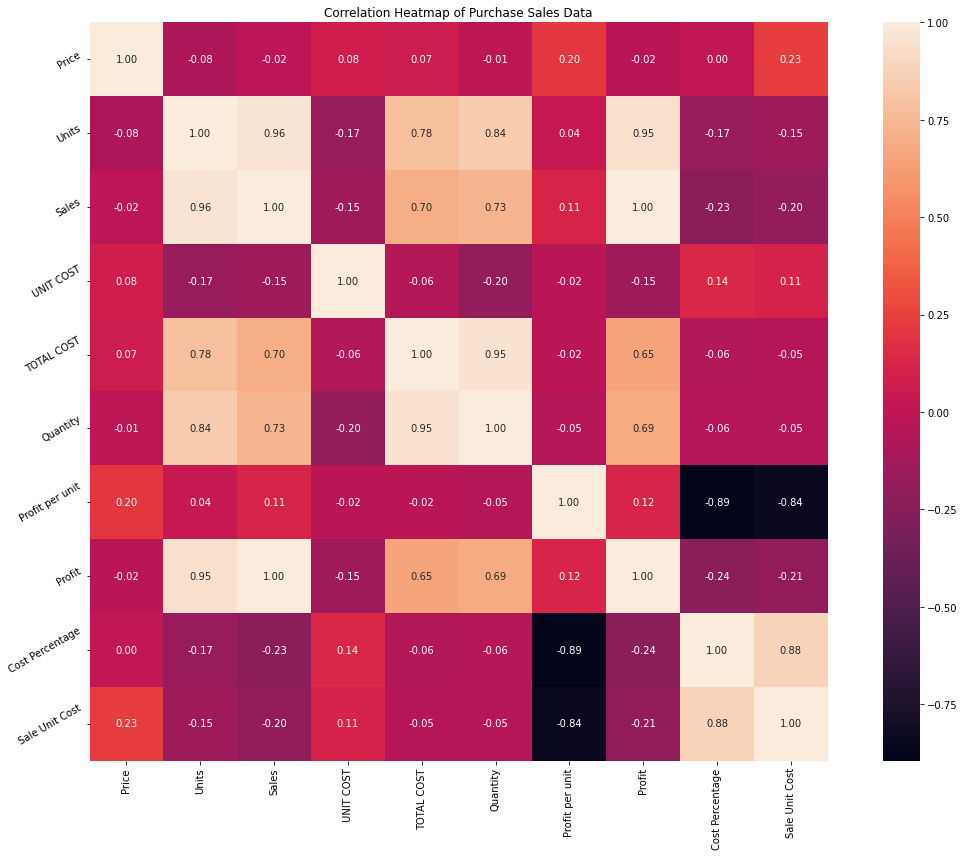

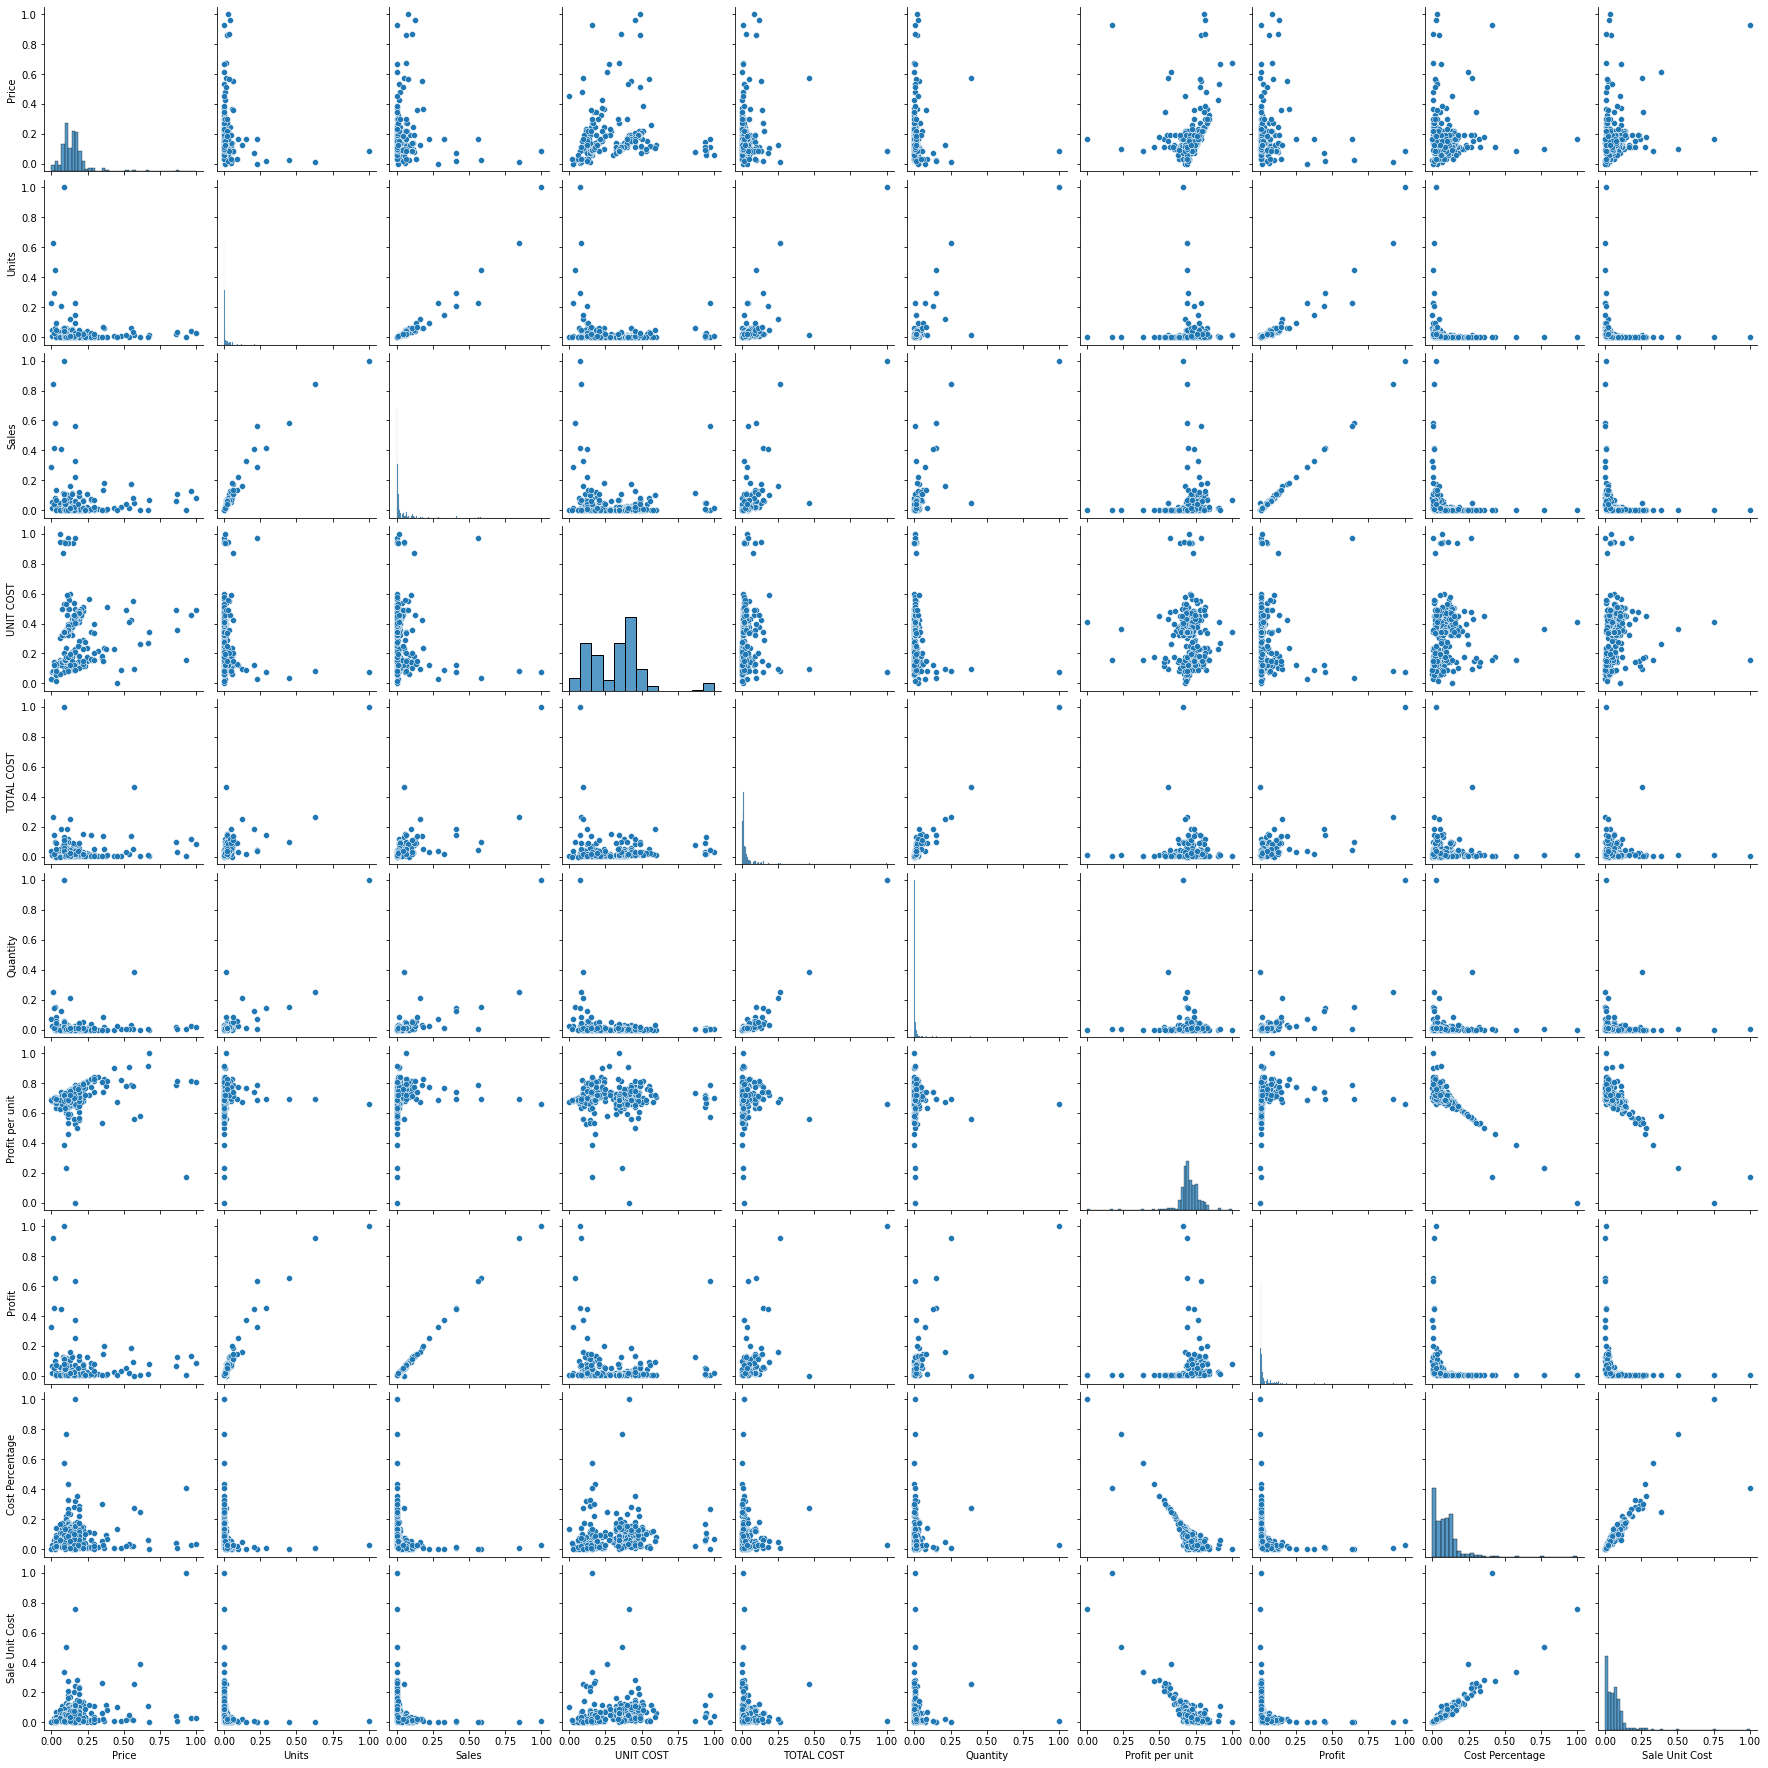

In [18]:
# Single Variable EDA
# Check purchase_sales_joint for any null values
purchase_sales_joint.isnull().values.any()

eda_rows = ['Maximum','Minimum','Mean','Median','Standard Deviation','Variance','Inter-quartile Range','Skewness','Kurtosis']
# create empty lists to store values
maximum=[]
minimum=[]
mean=[]
median=[]
standard_deviation=[]
variance = []
IQR=[]
skew=[]
kurt=[]

# Create metrics dataframe
purchase_sales_joint_numeric = purchase_sales_joint.copy()
purchase_sales_joint_numeric = purchase_sales_joint_numeric.drop(["Year","Category","Category_2","ORDER DATE","Type",
                                                                  "DISTRIBUTOR","ORDER UNIT"], axis=1)
purchase_sales_joint_numeric_columns = purchase_sales_joint_numeric.columns.tolist()

for i in purchase_sales_joint_numeric_columns:
    maximum.append(purchase_sales_joint_numeric[i].max())
    minimum.append(purchase_sales_joint_numeric[i].min())
    mean.append(purchase_sales_joint_numeric[i].mean())
    median.append(purchase_sales_joint_numeric[i].median())
    standard_deviation.append(purchase_sales_joint_numeric[i].std())
    variance.append(purchase_sales_joint_numeric[i].var())
    Q1 = purchase_sales_joint_numeric[i].quantile(0.25)
    Q3 = purchase_sales_joint_numeric[i].quantile(0.75)
    IQR.append(Q3-Q1)
    skew.append(purchase_sales_joint_numeric[i].skew())
    kurt.append(purchase_sales_joint_numeric[i].kurtosis())

purchase_sales_joint_metrics = pd.DataFrame([maximum, minimum, mean, median, standard_deviation, variance, IQR, skew, kurt])
purchase_sales_joint_metrics.columns = purchase_sales_joint_numeric_columns
purchase_sales_joint_metrics.insert(0, 'Metrics', eda_rows)
print(purchase_sales_joint_metrics)

# Box Plots
fig = make_subplots(rows=1, cols=10)
for count, variable in enumerate(purchase_sales_joint_numeric_columns):
    fig.add_trace(go.Box(y=purchase_sales_joint[variable], name=variable, marker_color='#3D9970', boxmean=True, 
                       boxpoints='outliers',fillcolor='#2bc531',
                       quartilemethod="linear", showlegend=False),row=1,col=count+1)

fig.update_layout(height=750, width=1750, title_text="Boxplots of Purchase Sales Joint Data")

fig.show()

# Histogram
purchase_sales_joint_categorical = purchase_sales_joint.copy()
purchase_sales_joint_categorical = purchase_sales_joint_categorical.drop(["Year","ORDER DATE","Price","Units","Sales","UNIT COST","ORDER UNIT","TOTAL COST",
                                                                 "Quantity","Profit per unit","Cost Percentage",
                                                                  "Sale Unit Cost", "Profit"], axis=1)
purchase_sales_joint_categorical_columns = purchase_sales_joint_categorical.columns.tolist()

for category in purchase_sales_joint_categorical_columns:
    plt.figure(figsize=(16,8))
    purchase_sales_joint_categorical[category].value_counts().plot.bar()
    plt.xlabel(category, fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.show()
    
# continue working on this
# Normalization
# setting scaler option to 0,1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(purchase_sales_joint_numeric)

# normalize
norm_purchase_sales_joint = scaler.transform(purchase_sales_joint_numeric).T
# create empty dataframe and append column values with column name by iteration
norm_purchase_sales_joint_df = pd.DataFrame()
for count, variable in enumerate(purchase_sales_joint_numeric_columns):
    norm_purchase_sales_joint_df[variable]=norm_purchase_sales_joint[count]
# show normalized cancer dataframe
norm_purchase_sales_joint_df
# Box Plots of Normalized Purchase Sales Joint Data
fig = make_subplots(rows=1, cols=10)
for count, variable in enumerate(purchase_sales_joint_numeric_columns):
    fig.add_trace(go.Box(y=norm_purchase_sales_joint_df
[variable], name=variable, marker_color='#3D9970', boxmean=True, 
                       boxpoints='outliers',fillcolor='#2bc531',
                       quartilemethod="linear", showlegend=False),row=1,col=count+1)

fig.update_layout(height=750, width=1750, title_text="Boxplots of Normalized Purchase Sales Joint Data")

fig.show()
norm_purchase_sales_joint_df

# Multivariable EDA
# Heatmap using normalized data
# compute pairwise pearson correlation of columns, excluding null values
correlation = norm_purchase_sales_joint_df.corr(method='pearson')
# plotting the heatmap
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Purchase Sales Data')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)   
plt.tight_layout()        
plt.show()

# Pair Plots
response_factors = purchase_sales_joint_numeric_columns
# plot pairplot using seaborn
sns.pairplot(norm_purchase_sales_joint_df[response_factors], kind='scatter', diag_kind='hist')
plt.show()

### Product Pricing Optimization

#### Adding Price Level Column

In [19]:
all_sales=pd.read_csv('All_Sales.csv')
all_sales_agg=all_sales.groupby(['Name'],as_index=False).agg({'Price':'max','Units':'sum','Sales':'sum','Category_2':'first'})
elasticity_model=pd.read_csv('Elasticity Model.csv')

conditons=[
    (all_sales_agg['Category_2']=='Beer') & (all_sales_agg['Price']>=8),
    (all_sales_agg['Category_2']=='Beer') & (all_sales_agg['Price']<8) & (all_sales_agg['Price']>=4),
    (all_sales_agg['Category_2']=='Beer') & (all_sales_agg['Price']<4),
    (all_sales_agg['Category_2']=='Wine'),
    (all_sales_agg['Category_2']=='Spirits') & (all_sales_agg['Price'] >= 10),
    (all_sales_agg['Category_2']=='Spirits') & (all_sales_agg['Price'] < 10) & (all_sales_agg['Price'] >= 5),
    (all_sales_agg['Category_2']=='Spirits') & (all_sales_agg['Price'] < 5)
]
categories =['High','Medium','Low','Medium','High','Medium','Low']
all_sales_agg['Price_Level']=np.select(conditons,categories,default='Unknown')

#### Defining Optimization Function

In [20]:
def revenue(increases):
    prod_list=all_sales_agg
    type_category=['Wine','Beer','Spirits']
    price_levels=['High','Medium','Low']

    coefficients=pd.read_csv('Elasticity Model.csv')
    data_combine=prod_list
    data_combine['increase']=increases
    data_combine['new_price']=(1+data_combine['increase']/100)*data_combine['Price']
    cat_increases=data_combine.groupby(['Category_2','Price_Level'],as_index=False).agg({'new_price':'sum','Price':'sum'})
    cat_increases['cat_increase']=cat_increases['new_price']/cat_increases['Price']
    price_increase_vector=[]

    for cat in type_category:
        for level in price_levels:
            if (cat=='Wine' and (level=='High' or level=='Low')):
                price_increase_vector.append(0)
            else:
                price_increase_vector.append(cat_increases.loc[(cat_increases['Category_2']==cat) & (cat_increases['Price_Level']==level)]['cat_increase'])

    demand_increase=[]

    for cat in type_category:
        for level in price_levels:
            coefficient_col=coefficients[cat+ ' '+level]
            coefficient_col.to_list()
            
            demand_increase=[x*y for (x,y) in zip(price_increase_vector,coefficient_col)]
    conditons=[
        (prod_list['Category_2']=='Wine'),
        (prod_list['Category_2']=='Beer') & (prod_list['Price_Level']=='High'),
        (prod_list['Category_2']=='Beer') & (prod_list['Price_Level']=='Medium'),
        (prod_list['Category_2']=='Beer') & (prod_list['Price_Level']=='Low'),
        (prod_list['Category_2']=='Spirits') & (prod_list['Price_Level'] =='High'),
        (prod_list['Category_2']=='Spirits') & (prod_list['Price_Level'] =='Medium'),
        (prod_list['Category_2']=='Spirits') & (prod_list['Price_Level'] == 'Low')
    ]
    func=[
    demand_increase[1],
    demand_increase[3],
    demand_increase[4],
    demand_increase[5],
    demand_increase[6],
    demand_increase[7],
    demand_increase[8]
        ]
    prod_list['Demand Increase']=np.select(conditons,func,default='Unknown')
    prod_list['New Demand']=(1+prod_list['Demand Increase'].astype(float))*prod_list['Units'].astype(float)
    revenue=-(prod_list['New Demand']*data_combine['new_price']).sum()
    return revenue

#### Unconstrained Optimization

In [21]:
prod_list=all_sales_agg
increases=[10]*len(prod_list.index)
#res=minimize(revenue,increases,method='BFGS',options={'disp':True})
#Don't run in all run because it takes too long

Unconstrained optimization yields unrealistic markups and mark downs therefore we must utilize constrained optimization with a bound placed on the discount rate.

#### Constrained Optimization

#### Constrain optimization to only positive price increases with cap at that studied in paper.

In [22]:

prod_list=all_sales_agg
increases=[10]*len(prod_list.index)
res_2=minimize(revenue,increases,method='SLSQP',bounds=Bounds(0,30))
#don't run in all run because it takes too long

#### Optimization Recommendations

In [23]:
prices_recommended=pd.DataFrame()
increases=res_2.x
prices_recommended['Name']=all_sales_agg['Name']
prices_recommended['Price']=all_sales_agg['Price']
prices_recommended['Increase']=increases
prices_recommended['New Price']=(prices_recommended['Price'].astype(float)*(1+prices_recommended['Increase'].astype(float)/100)).round(2)
print(prices_recommended.head)
revenue_change=revenue(increases)-revenue([0]*len(all_sales_agg))
print(-revenue_change)
percent_revenue_change=(revenue(increases)/revenue([0]*len(all_sales_agg)))-1
print(percent_revenue_change.round(4))

<bound method NDFrame.head of                         Name  Price  Increase  New Price
0    $5 Old Fasioned Mondays   5.00      30.0       6.50
1           $5 vELO carbombs   4.43      30.0       5.76
2          $7 Irish  Goodbye   7.00      30.0       9.10
3            10.30 drag shot   4.00      30.0       5.20
4              11.4 Cocktail   5.00      30.0       6.50
..                       ...    ...       ...        ...
672         Woffler Dry Rose   9.00      30.0      11.70
673         Woodford Reserve   7.50      30.0       9.75
674              Woodinville   8.50      30.0      11.05
675     Young's Double Choc    8.00      30.0      10.40
676                   Zephyr   7.00       0.0       7.00

[677 rows x 4 columns]>
629322.1549145067
0.3124


### Multinomial Linear Regression


#### Adding price level column

In [24]:
conditons=[
    (purchase_sales_joint['Category_2']=='Beer') & (purchase_sales_joint['Price']>=8),
    (purchase_sales_joint['Category_2']=='Beer') & (purchase_sales_joint['Price']<8) & (purchase_sales_joint['Price']>=4),
    (purchase_sales_joint['Category_2']=='Beer') & (purchase_sales_joint['Price']<4),
    (purchase_sales_joint['Category_2']=='Wine'),
    (purchase_sales_joint['Category_2']=='Spirits') & (purchase_sales_joint['Price'] >= 10),
    (purchase_sales_joint['Category_2']=='Spirits') & (purchase_sales_joint['Price'] < 10) & (purchase_sales_joint['Price'] >= 5),
    (purchase_sales_joint['Category_2']=='Spirits') & (purchase_sales_joint['Price'] < 5)
]
categories =['High','Medium','Low','Medium','High','Medium','Low']
purchase_sales_joint['Price_Level']=np.select(conditons,categories,default='Unknown')

#### Recoding dummy variables

In [25]:
y=purchase_sales_joint['Profit']
x=purchase_sales_joint[['Price','Year','Category_2','Sale Unit Cost','Price_Level']]

years=pd.get_dummies(x['Year'])
x=x.drop(columns=['Year']).join(years)

categories=pd.get_dummies(x['Category_2'])
x=x.drop(columns=['Category_2']).join(categories)

price_levels=pd.get_dummies(x['Price_Level'])
x=x.drop(columns=['Price_Level']).join(price_levels)

#### Utilize Matrix Based Multinomial Linear Regression

In [26]:
def linear_regression_multi(factor,response):

    x_0=np.ones(response.shape)
    x_0=x_0.reshape(-1,1)
    
    for col in factor.columns:
        x=factor[col].to_numpy()
        x=x.reshape(-1,1)
        x_0=np.hstack((x_0,x))
    x=x_0    
    y=response.to_numpy()
    w=np.linalg.inv(x.T @ x) @x.T @ y
    y_p=np.dot(x,w)
    mse = metrics.mean_squared_error(y,y_p)
    return w, y_p, mse

In [27]:
w, y_p, mse=linear_regression_multi(x,y)
mse

107920192.23651718

This MSE is very high therefore we can conclude that the matrix based method is not good at predicting profit.

#### Machine Learning Based Linear Regression

C:\Users\joepa\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\joepa\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



45304961.27849366


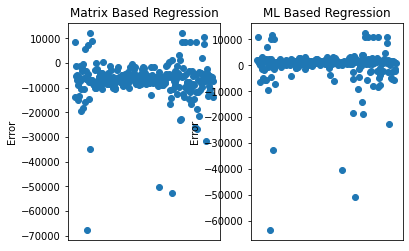

In [28]:
#%matplotlib qt
regr=linear_model.LinearRegression()
regr.fit(x,y)
y_p_ml=regr.predict(x)
all=x
all['y']=y
all['y_p']=y_p
print(metrics.mean_squared_error(y,y_p_ml))
fig, ax=plt.subplots(1,2)
ax[0].scatter(x.index,y_p-y)
ax[0].set_xlabel('Product Index')
ax[0].set_ylabel('Error')
ax[0].set_title('Matrix Based Regression')
ax[0].get_xaxis().set_visible(False)
ax[1].scatter(x.index,y_p_ml-y)
ax[1].set_xlabel('Product Index')
ax[1].set_ylabel('Error')
ax[1].set_title('ML Based Regression')
ax[1].get_xaxis().set_visible(False)

MSE is also very bad, meaning this is probably just not a linear model. Lets try predicting profit per unit instead of profit. This indicates that profit is probably not highly correlated with the type of item, the year, the price, and the per unit cost. 

In [29]:
y=purchase_sales_joint['Profit per unit']
x=purchase_sales_joint[['Price','Year','Category_2','Sale Unit Cost','Price_Level']]

years=pd.get_dummies(x['Year'])
x=x.drop(columns=['Year']).join(years)

categories=pd.get_dummies(x['Category_2'])
x=x.drop(columns=['Category_2']).join(categories)

price_levels=pd.get_dummies(x['Price_Level'])
x=x.drop(columns=['Price_Level']).join(price_levels)
regr=linear_model.LinearRegression()
regr.fit(x,y)
y_p=regr.predict(x)
all=x
all['y']=y
all['y_p']=y_p
metrics.mean_squared_error(y,y_p)

C:\Users\joepa\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\joepa\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



0.39670789878024587

This yields a much better MSE. It is not meaningful however because profit per unit is directly calculated from price and order cost per unit. Lets try to predict Sales instead as this is more meaningful.

In [30]:
y=purchase_sales_joint['Units']
x=purchase_sales_joint[['Price','Year','Category_2','Sale Unit Cost','Price_Level']]

years=pd.get_dummies(x['Year'])
x=x.drop(columns=['Year']).join(years)

categories=pd.get_dummies(x['Category_2'])
x=x.drop(columns=['Category_2']).join(categories)

price_levels=pd.get_dummies(x['Price_Level'])
x=x.drop(columns=['Price_Level']).join(price_levels)
regr=linear_model.LinearRegression()
regr.fit(x,y)
y_p=regr.predict(x)
all=x
all['y']=y
all['y_p']=y_p
metrics.mean_squared_error(y,y_p)

C:\Users\joepa\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\joepa\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



4315087.588334614

Again, prediction is very bad. We can likely conclude that these values do not exhibit a linear relationship.

### Competitor Analysis

In [31]:
competitor_data=pd.read_csv('Competitor Data.csv')
print(competitor_data.head())

  Competitor         Item       Category   Type  Price
0    Society          PBR  Beer Can Base  Lager      3
1    Society  Miller Lite  Beer Can Base  Lager      4
2    Society    Bud Light  Beer Can Base  Lager      4
3    Society  Coors Light  Beer Can Base  Lager      4
4    Society   Mich Ultra  Beer Can Base  Lager      4


In [32]:
all_sales_comp=all_sales.loc[all_sales['Category_2']=='Beer']
all_sales_comp=all_sales_comp[all_sales_comp['Name'].str.contains('Draft')==False]
all_sales_agg_comp=all_sales_comp.groupby('Name').agg({'Price':'mean','Units':'sum'})
all_sales_agg_comp=all_sales_agg_comp.loc[all_sales_agg_comp['Price']<=12]

Now that we have datasets from competitors and the bar with similar products lets do a price comparison. 

Velo has a mean can beer price of 5.80 with a standard deviation of 1.60.
Competitors have a mean can beer price of 5.87 with a standard deviation of 1.54.


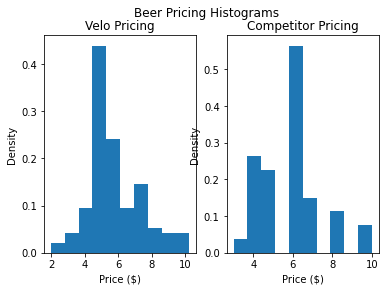

In [33]:
fig, ax=plt.subplots(1,2)
fig.suptitle('Beer Pricing Histograms')
ax[1].hist(competitor_data['Price'],density=True)
ax[1].set_xlabel('Price ($)')
ax[1].set_ylabel('Density')
ax[0].hist(all_sales_agg_comp['Price'],density=True)
ax[0].set_xlabel('Price ($)')
ax[0].set_ylabel('Density')
ax[0].set_title('Velo Pricing')
ax[1].set_title('Competitor Pricing')
mean_velo=np.mean(all_sales_agg_comp['Price'])
mean_comp=np.mean(competitor_data['Price'])
std_velo=np.std(all_sales_agg_comp['Price'])
std_comp=np.std(competitor_data['Price'])

print(f'Velo has a mean can beer price of {mean_velo:.2f} with a standard deviation of {std_velo:.2f}.')
print(f'Competitors have a mean can beer price of {mean_comp:.2f} with a standard deviation of {std_comp:.2f}.')

Velo has a very similar canned beer pricing scheme to its competitors but lets also check against data weighted for sales. We will have to assume competitors sell products equally.

Text(0, 0.5, 'Density')

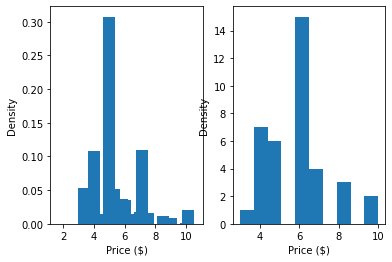

In [34]:
all_sales_agg_comp['Weight']=all_sales_agg_comp['Units']/all_sales_agg_comp['Units'].sum()
all_sales_agg_comp_prices=all_sales_agg_comp.groupby('Price',as_index=False).agg({'Weight':'sum'})
fig, ax=plt.subplots(1,2)
ax[0].bar(all_sales_agg_comp_prices['Price'],all_sales_agg_comp_prices['Weight'])
ax[0].set_xlabel('Price ($)')
ax[0].set_ylabel('Density')
ax[1].hist(competitor_data['Price'])
ax[1].set_xlabel('Price ($)')
ax[1].set_ylabel('Density')



In [35]:
i=0
cumm=np.zeros(len(all_sales_agg_comp_prices.index))
for price in all_sales_agg_comp_prices['Price']:
    cumm[i]=all_sales_agg_comp_prices.loc[all_sales_agg_comp_prices['Price']<=price]['Weight'].sum()
    i=i+1
all_sales_agg_comp_prices['Cummulative']=cumm
mean_velo=all_sales_agg_comp_prices.iloc[all_sales_agg_comp_prices[all_sales_agg_comp_prices['Cummulative'].gt(.5)].index[0]]['Price']
std_velo=(pow((all_sales_agg_comp['Price'].astype(float)-mean_velo.astype(float)),2)*all_sales_agg_comp['Weight'].astype(float)).sum()
print(f'Velo has a mean can beer price of {mean_velo:.2f} with a standard deviation of {std_velo:.2f}.')
print(f'Competitors have a mean can beer price of {mean_comp:.2f} with a standard deviation of {std_comp:.2f}.')

Velo has a mean can beer price of 4.96 with a standard deviation of 1.96.
Competitors have a mean can beer price of 5.87 with a standard deviation of 1.54.


With unit sale weights taken into account, Velo has a lesser can beer price.

### Change Analysis

#### Get top 10 sellers for each year

##### Normalize for sales per year

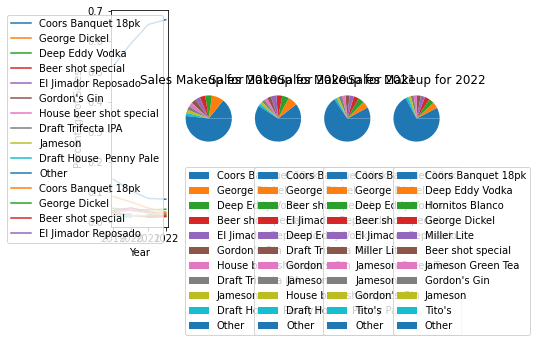

In [36]:
#%matplotlib qt
sales_change_df=all_sales
sales_2019=sales_change_df.loc[sales_change_df['Year']==2019]
sales_2020=sales_change_df.loc[sales_change_df['Year']==2020]
sales_2021=sales_change_df.loc[sales_change_df['Year']==2021]
sales_2022=sales_change_df.loc[sales_change_df['Year']==2022]

sales_2019['Unit_Percentage']=sales_2019['Units']/sales_2019['Units'].sum()
sales_2020['Unit_Percentage']=sales_2020['Units']/sales_2020['Units'].sum()
sales_2021['Unit_Percentage']=sales_2021['Units']/sales_2021['Units'].sum()
sales_2022['Unit_Percentage']=sales_2022['Units']/sales_2022['Units'].sum()


top_10_2019=sales_2019.sort_values(['Unit_Percentage'],ascending=False).head(10)
top_10_2019=pd.concat([top_10_2019,sales_2019.sort_values(['Unit_Percentage'],ascending=False).iloc[10:,:].groupby('Year',as_index=False).agg({'Unit_Percentage':'sum'})])
top_10_2019['Name']=top_10_2019['Name'].fillna('Other')
top_10_2020=sales_2020.sort_values(['Unit_Percentage'],ascending=False).head(10)
top_10_2020=pd.concat([top_10_2020,sales_2020.sort_values(['Unit_Percentage'],ascending=False).iloc[10:,:].groupby('Year',as_index=False).agg({'Unit_Percentage':'sum'})])
top_10_2020['Name']=top_10_2020['Name'].fillna('Other')
top_10_2021=sales_2021.sort_values(['Unit_Percentage'],ascending=False).head(10)
top_10_2021=pd.concat([top_10_2021,sales_2021.sort_values(['Unit_Percentage'],ascending=False).iloc[10:,:].groupby('Year',as_index=False).agg({'Unit_Percentage':'sum'})])
top_10_2021['Name']=top_10_2021['Name'].fillna('Other')
top_10_2022=sales_2022.sort_values(['Unit_Percentage'],ascending=False).head(10)
top_10_2022=pd.concat([top_10_2022,sales_2022.sort_values(['Unit_Percentage'],ascending=False).iloc[10:,:].groupby('Year',as_index=False).agg({'Unit_Percentage':'sum'})])
top_10_2022['Name']=top_10_2022['Name'].fillna('Other')

all_top_10=pd.concat([top_10_2019,top_10_2020,top_10_2021,top_10_2022])

figure, ax = plt.subplots(1,5)
for name in all_top_10['Name'].unique():
    ax[0].plot(all_top_10.loc[all_top_10['Name']==name]['Year'],all_top_10.loc[all_top_10['Name']==name]['Unit_Percentage'])
ax[0].legend(all_top_10['Name'])
ax[0].set_xticks([2019,2020,2021,2022])
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Percentage of Sales')
i=1
for year in all_top_10['Year'].unique():
    ax[i].pie(all_top_10.loc[all_top_10['Year']==year]['Unit_Percentage'])
    ax[i].legend(all_top_10.loc[all_top_10['Year']==year]['Name'],bbox_to_anchor=(0,-.25), loc="upper left")
    ax[i].set_title(f'Sales Makeup for {year}')
    i=i+1

These graph's indicate the the bars core sales are shifting from its top 10 products to a more diverse array of products over the years.